In [1]:

import os, sys
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from statsmodels.tsa.seasonal import seasonal_decompose
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize

In [2]:

# Get theconda create --name talib python=3.9 current working directory
current_dir = os.getcwd()
print("current_dir: ",current_dir)

# Get the parent directory
parent_dir = os.path.dirname(current_dir)
print("parent_dir",parent_dir)

# Insert the path to the parent directory
sys.path.insert(0, parent_dir)



current_dir:  d:\Kifya\Week_01\notebooks
parent_dir d:\Kifya\Week_01


In [3]:
import pandas as pd

# read the CSV 
data = pd.read_csv('../data/raw_analyst_ratings.csv')

data.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [6]:
data.shape

(1407328, 6)

In [7]:
print(data.isnull().sum())

Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1407328 non-null  int64 
 1   headline    1407328 non-null  object
 2   url         1407328 non-null  object
 3   publisher   1407328 non-null  object
 4   date        1407328 non-null  object
 5   stock       1407328 non-null  object
dtypes: int64(1), object(5)
memory usage: 64.4+ MB


Descriptive Statistics:

In [9]:
df=data.copy()

In [10]:
df.shape

(1407328, 6)

In [12]:
# Measure the length of each headline in terms of characters
df['headline_length_chars'] = df['headline'].apply(len)

# Measure the length of each headline in terms of words
df['headline_length_words'] = df['headline'].apply(lambda x: len(x.split()))

# Calculate basic statistics for character length
char_stats = df['headline_length_chars'].describe()
print("Character Length Statistics:\n", char_stats)


Character Length Statistics:
 count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length_chars, dtype: float64


In [13]:
# Calculate basic statistics for word length
word_stats = df['headline_length_words'].describe()
print("Word Length Statistics:\n", word_stats)

Word Length Statistics:
 count    1.407328e+06
mean     1.141671e+01
std      6.352997e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.300000e+01
max      7.700000e+01
Name: headline_length_words, dtype: float64


In [14]:
# Count the number of articles per publisher
publisher_counts = df['publisher'].value_counts()
print("Top Publishers by Article Count:\n", publisher_counts.head())

Top Publishers by Article Count:
 publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Name: count, dtype: int64


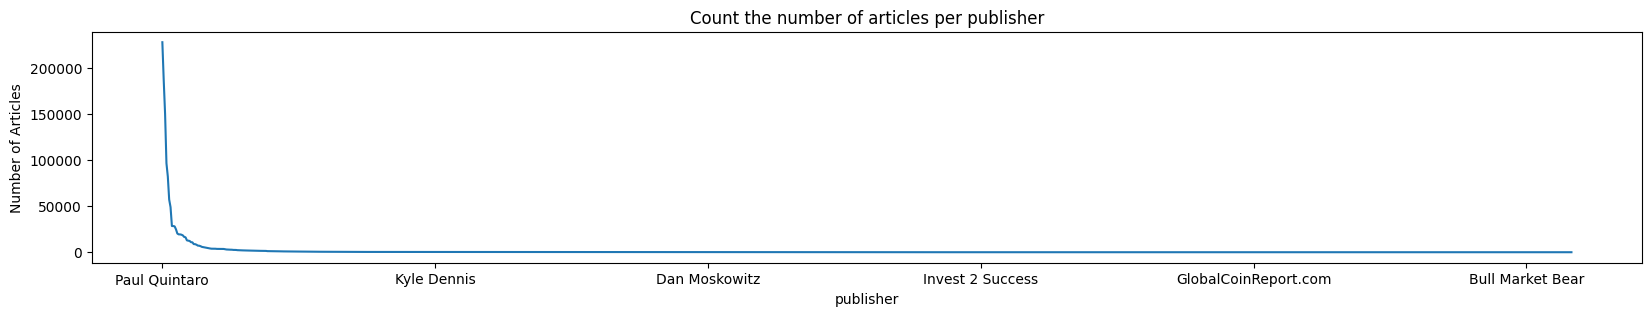

In [17]:
plt.figure(figsize=(20, 3))
publisher_counts.plot(kind='line', title='Count the number of articles per publisher')
plt.xlabel('publisher')
plt.ylabel('Number of Articles')
plt.show()

In [25]:

# Remove timezone information and convert to datetime

# Step 1: Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Step 2: Remove timezone information (if any)
df['local_date'] = df['date'].dt.tz_localize(None)
df['date_only'] = df['date'].dt.date

df.head()

,Unnamed: 0,headline,url,publisher,date,stock,headline_length,headline_length_chars,headline_length_words,local_date,date_only
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,39,39,7,2020-06-05 10:30:54,2020-06-05
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,42,42,7,2020-06-03 10:45:20,2020-06-03
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,29,29,5,2020-05-26 04:30:07,2020-05-26
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,44,44,7,2020-05-22 12:45:06,2020-05-22
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,87,87,14,2020-05-22 11:38:59,2020-05-22


In [92]:
hourly_count=df['hour_of_day'] = df['date'].dt.hour
# Plot yearly publication trends
plt.figure(figsize=(10, 4))
hourly_count.plot(kind='bar', title='Number of Articles Published Per hour')
plt.xlabel('hour')
plt.ylabel('Number of Articles')
plt.show()

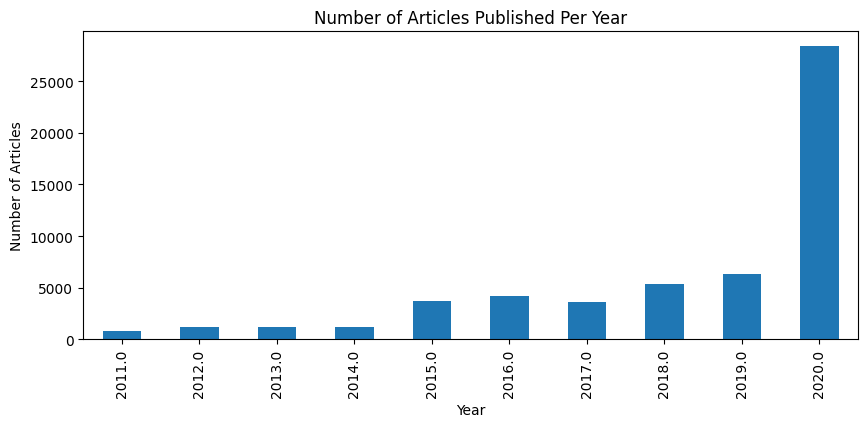

<Figure size 1400x400 with 0 Axes>

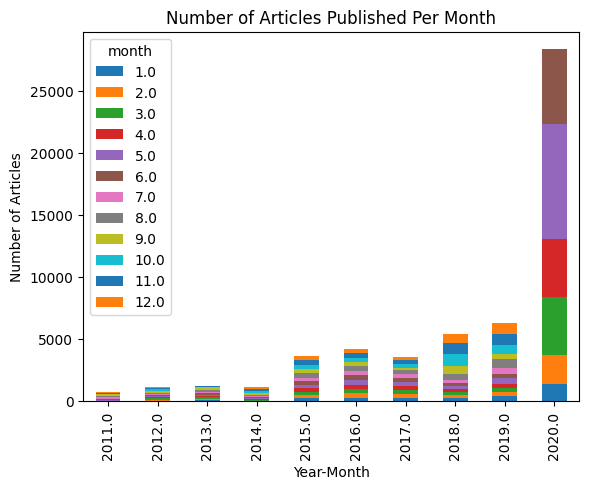

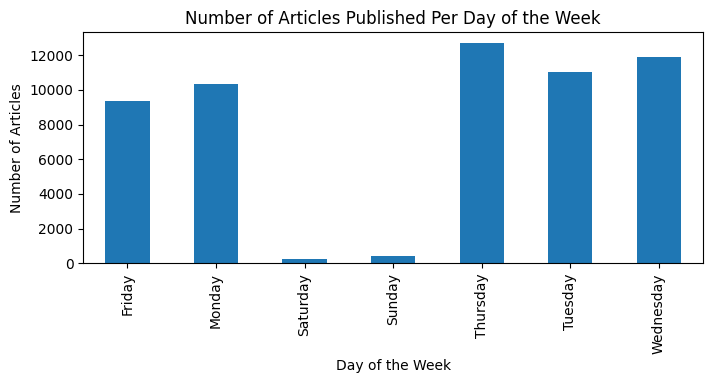

In [30]:


# Step 2: Extract year, month, and day components
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.day_name()  # This will give day names like 'Monday', 'Tuesday', etc.

# Step 3: Group and count the data
# Count the number of articles published per year
yearly_counts = df.groupby('year').size()

# Count the number of articles published per month
monthly_counts = df.groupby(['year', 'month']).size()

# Count the number of articles published on each day of the week
weekly_counts = df.groupby('day_of_week').size()

# Step 4: Visualize the Data

# Plot yearly publication trends
plt.figure(figsize=(10, 4))
yearly_counts.plot(kind='bar', title='Number of Articles Published Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.show()

# Plot monthly publication trends
plt.figure(figsize=(14, 4))
monthly_counts.unstack().plot(kind='bar', stacked=True, title='Number of Articles Published Per Month')
plt.xlabel('Year-Month')
plt.ylabel('Number of Articles')
plt.show()

# Plot weekly publication trends
plt.figure(figsize=(8, 3))
weekly_counts.plot(kind='bar', title='Number of Articles Published Per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Articles')
plt.show()


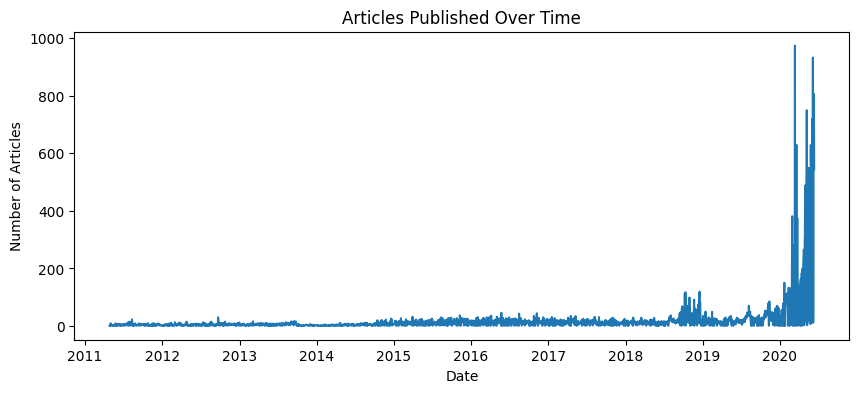

In [32]:
# Count the number of articles published per day
daily_counts = df['date_only'].value_counts().sort_index()
plt.figure(figsize=(10, 4))
daily_counts.plot(kind='line', title='Articles Published Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()

Text Analysis(Sentiment analysis & Topic Modeling):


1.Sentiment Analysis

In [34]:
df[:3]

,Unnamed: 0,headline,url,publisher,date,stock,headline_length,headline_length_chars,headline_length_words,local_date,date_only,year,month,day,day_of_week
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,39,39,7,2020-06-05 10:30:54,2020-06-05,2020.0,6.0,5.0,Friday
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,42,42,7,2020-06-03 10:45:20,2020-06-03,2020.0,6.0,3.0,Wednesday
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,29,29,5,2020-05-26 04:30:07,2020-05-26,2020.0,5.0,26.0,Tuesday


In [14]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\asmam\AppData\Roaming\nltk_data...


True

In [38]:
sentiment_data=data.copy()
sentiment_data.head()

,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [39]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()
# Calculate the sentiment of the headlines
sentiment_data['sentiment'] = sentiment_data['headline'].apply(lambda x: sia.polarity_scores(text=x)['compound'])

In [40]:
sentiment_data.head()

,Unnamed: 0,headline,url,publisher,date,stock,sentiment
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,0.000
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,0.000
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,0.000
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,0.000
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,0.296


In [41]:
# Categorize the sentiment scores
sentiment_data['sentiment_category'] = pd.cut(sentiment_data['sentiment'], bins=[-1, -0.5, -0.0001, 0.5, 1], labels=['Very Negative', 'Negative', 'Neutral', 'Positive'])
sentiment_data.head()

,Unnamed: 0,headline,url,publisher,date,stock,sentiment,sentiment_category
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,0.000,Neutral
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,0.000,Neutral
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,0.000,Neutral
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,0.000,Neutral
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,0.296,Neutral


In [46]:
sentiment_data['sentiment_category'].value_counts()

sentiment_category
Neutral          1070915
Negative          182864
Positive          109718
Very Negative      43831
Name: count, dtype: int64

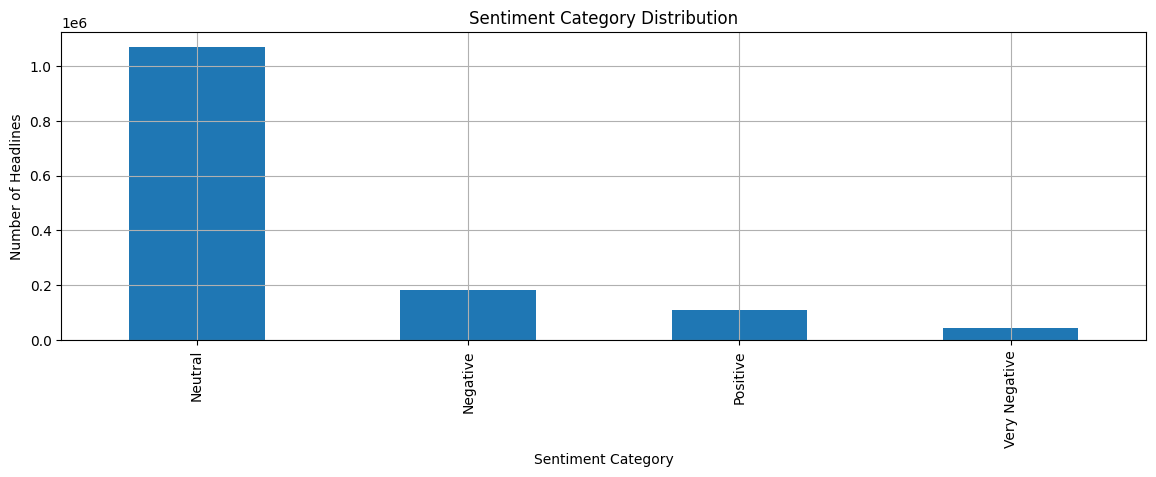

In [55]:
plt.figure(figsize=(14, 4))
sentiment_data['sentiment_category'].value_counts().plot(kind='bar', title='Sentiment Category Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Headlines')
plt.grid(True)
plt.show()

In [62]:
unique_stock_count = sentiment_data['stock'].nunique()
unique_stock_count

6204

In [68]:
sentiment_data['stock'].value_counts()

stock
MRK      3333
MS       3238
NVDA     3146
MU       3142
QQQ      3106
         ... 
ADZ         1
ADRD        1
ACCU        1
NGHCP       1
ZMLP        1
Name: count, Length: 6204, dtype: int64

In [63]:
# AAPLE
apple_data = sentiment_data[sentiment_data['stock'] == 'AAPL']
apple_data

,Unnamed: 0,headline,url,publisher,date,stock,sentiment,sentiment_category
6680,7120,Tech Stocks And FAANGS Strong Again To Start D...,https://www.benzinga.com/government/20/06/1622...,JJ Kinahan,2020-06-10 11:33:26-04:00,AAPL,0.5574,Positive
6681,7121,10 Biggest Price Target Changes For Wednesday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-06-10 08:14:08-04:00,AAPL,0.0000,Neutral
6682,7122,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",https://www.benzinga.com/short-sellers/20/06/1...,Benzinga Newsdesk,2020-06-10 07:53:47-04:00,AAPL,0.2023,Neutral
6683,7123,"Deutsche Bank Maintains Buy on Apple, Raises P...",https://www.benzinga.com/news/20/06/16219873/d...,Benzinga Newsdesk,2020-06-10 07:19:25-04:00,AAPL,0.0000,Neutral
6684,7124,Apple To Let Users Trade In Their Mac Computer...,https://www.benzinga.com/news/20/06/16218697/a...,Neer Varshney,2020-06-10 06:27:11-04:00,AAPL,0.3818,Neutral
...,...,...,...,...,...,...,...,...
7116,7585,"UBS Maintains Buy on Apple, Lowers Price Targe...",https://www.benzinga.com/news/20/03/15514989/u...,Vick Meyer,2020-03-10 00:00:00,AAPL,-0.1280,Negative
7117,7586,123 Biggest Movers From Yesterday,https://www.benzinga.com/news/20/03/15514298/1...,Lisa Levin,2020-03-10 00:00:00,AAPL,0.0000,Neutral
7118,7587,Crude Awakening: Energy Sector Takes A 20% Spi...,https://www.benzinga.com/news/earnings/20/03/1...,JJ Kinahan,2020-03-09 00:00:00,AAPL,-0.9062,Very Negative
7119,7588,Investor Movement Index Summary: February 2020,https://www.benzinga.com/news/earnings/20/03/1...,TD Ameritrade,2020-03-09 00:00:00,AAPL,0.0000,Neutral


In [ ]:
apple_data = sentiment_data[sentiment_data['stock'] == 'AAPL']
apple_data

In [66]:
# AAPLE
data_A = sentiment_data[sentiment_data['stock'] == 'A']
data_A

,Unnamed: 0,headline,url,publisher,date,stock,sentiment,sentiment_category
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,0.0000,Neutral
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,0.0000,Neutral
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,0.0000,Neutral
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,0.0000,Neutral
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,0.2960,Neutral
...,...,...,...,...,...,...,...,...
1428,1830,"A Simulation of China's 2,$$$,$$$,$$$,$$$ Dive...",https://www.benzinga.com/9382/a-simulation-of-...,prudentinvestor,2009-08-04 00:00:00,A,0.0000,Neutral
1429,1831,The Gold/Silver Ratio From 1300 to 1900...And Now,https://www.benzinga.com/prudentinvestor/2009/...,prudentinvestor,2009-07-30 00:00:00,A,0.0000,Neutral
1430,1832,Skystar Bio-Pharmaceutical Announces Expansion...,https://www.benzinga.com/5329/skystar-bio-phar...,superman,2009-07-14 00:00:00,A,0.3818,Neutral
1431,1833,super-trades - Two 52 week highs and others ab...,https://www.benzinga.com/superman/2009/6/1/sup...,superman,2009-06-01 00:00:00,A,0.2960,Neutral


Topic Model using 

In [ ]:
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
# Download NLTK data (if not already installed)
nltk.download('punkt')
nltk.download('stopwords')

# Preprocess the headlines: Tokenization and removing stopwords
stop_words = set(stopwords.words('english'))
df['processed_headline'] = df['headline'].apply(lambda x: [word for word in word_tokenize(x.lower()) if word.isalnum() and word not in stop_words])

# Create a dictionary and corpus for topic modeling
dictionary = corpora.Dictionary(df['processed_headline'])
corpus = [dictionary.doc2bow(text) for text in df['processed_headline']]

# Perform LDA to extract topics
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)

# Print the topics identified
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

Time Series Analysis:

In [72]:
# Count headlines per day
time_series_data=data.copy()

daily_headlines = time_series_data.groupby('date').size()

# Create a DataFrame for time series analysis
time_series_data = pd.DataFrame({'Date': daily_headlines.index, 'Headlines_Count': daily_headlines.values})
time_series_data.set_index('Date', inplace=True)


In [73]:
print(time_series_data)

                           Headlines_Count
Date                                      
2009-02-14 00:00:00                      1
2009-04-27 00:00:00                      2
2009-04-29 00:00:00                      1
2009-05-22 00:00:00                      1
2009-05-27 00:00:00                      6
...                                    ...
2020-06-11 16:49:41-04:00                1
2020-06-11 16:51:33-04:00                1
2020-06-11 17:01:39-04:00                1
2020-06-11 17:11:20-04:00                1
2020-06-11 17:12:35-04:00                1

[39957 rows x 1 columns]


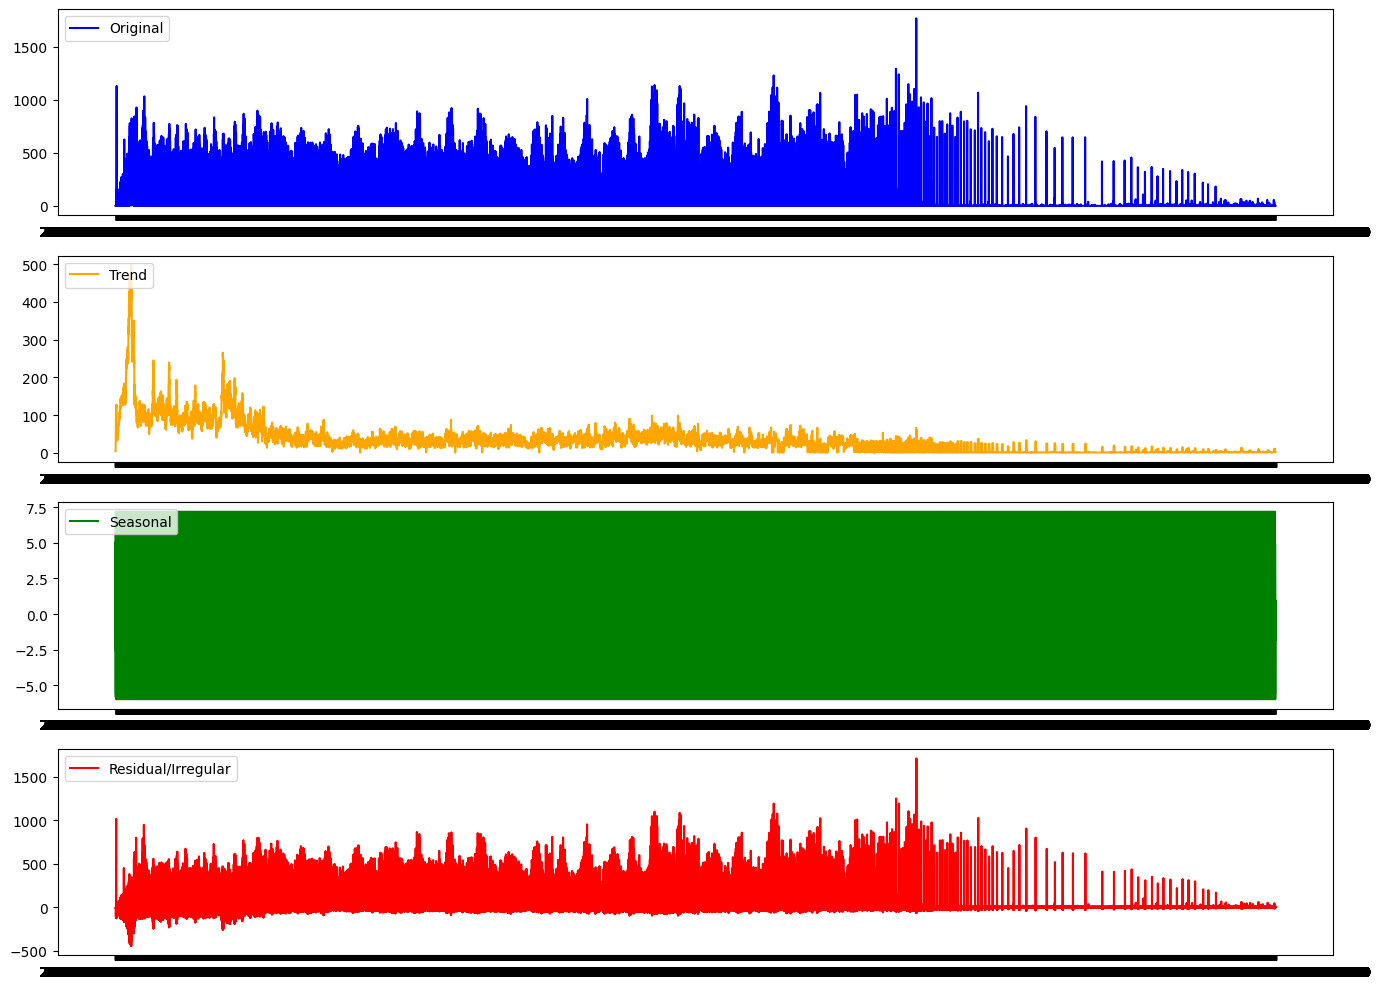

In [74]:
decomposition = seasonal_decompose(time_series_data['Headlines_Count'], model='additive', period=30)

# Plotting the components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(time_series_data['Headlines_Count'], label='Original', color='blue')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual/Irregular', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [84]:
import nltk

# Download the 'punkt' tokenizer data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asmam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asmam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [86]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\asmam\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [78]:
tf_data=data.copy()

In [87]:
# Assuming 'headline' column contains the text data
tf_data['headline'] = tf_data['headline'].astype(str)  # Ensure all data is string

# Text preprocessing function
def preprocess_text(text):
    # Remove punctuation and non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text.lower())
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Join tokens back into string
    return ' '.join(tokens)

# Apply preprocessing to the headlines
tf_data['cleaned_headline'] = tf_data['headline'].apply(preprocess_text)

In [88]:
tf_data.head()

,Unnamed: 0,headline,url,publisher,date,stock,cleaned_headline
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,stocks hit week highs friday
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,stocks hit week highs wednesday
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,biggest movers friday
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,stocks moving fridays midday session
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,b securities maintains neutral agilent technol...


In [90]:
# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(tf_data['cleaned_headline'])

# Get the feature names (i.e., words)
tfidf_feature_names = vectorizer.get_feature_names_out()


In [91]:
from sklearn.decomposition import LatentDirichletAllocation

# Set the number of topics
num_topics = 10

# Apply LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

# Display the topics
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
        print()

# Display the top 10 words for each topic
display_topics(lda, tfidf_feature_names, 10)


Topic #1:
session moving stocks premarket midday alert option wednesdays thursdays tuesdays

Topic #2:
benzingas movers upgrades downgrades biggest yesterday market update volume shares

Topic #3:
pt maintains buy raises target price neutral downgrades lowers initiates

Topic #4:
shares trading industry highest companies stocks lower oil higher amid

Topic #5:
earnings scheduled estimate watch february beats stocks august beat april

Topic #6:
scheduled benzingas earnings losers watch etfs october november march initiations

Topic #7:
says announces shares analyst deal new blog stake options ceo

Topic #8:
week stocks hit highs lows set new biggest thursday friday

Topic #9:
markets market update earnings stock futures news ahead higher shares

Topic #10:
vs est eps reports sales fy sees revenue adj yoy

